# Trabajo Práctico 1 - *NLP 2*
## **Implementaciones sobre TinyGPT**
### _Universidad de Buenos Aires - Facultad de Ingeniería - LSE_

- **Carrera:** Maestría en Inteligencia Artificial  
- **Curso:** Procesamiento del Lenguaje Natural II (Oct-2025)
- **Docentes:**
  - Ezequiel Guinsburg
  - Abraham Rodriguez
- **Autor:** Alejandro Lloveras *(a1716)*

# Assignment 1

**Author: Abraham R.**

The following notebook is an example of a really tiny GPT based model called TinyGPT.
You'll review the GPT architecture (transformer decoder) and implement the following tasks:

## TinyGPT Architecture

Tailored for the [NLP-II course](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) as we deal with architectures and theory, this model consists of a **Mixture of Experts GPT**, equivalent to models like:
- DeepSeek
- Mistral

## Tasks

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

## Architecture:
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

## What to expect?

- You'll manage to understand a depth implementation of a GPT model.
- Implement a MoE Layer to create a state-of-the art GPT model.
- Explore decoding algorithms for text generation.


### NOTE

Tokenization is out of scope, we'll use a simple yet ineffective character-based tokenizer.


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

## Downloading Dataset

In [4]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Character-based encoding

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# Train/test split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Dataloaders

In [6]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# GPT Configuration

In [7]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [8]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [11]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## TinyGPT Architecture

In [12]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits


## Generation function (inference)

In [13]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Setup

In [14]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [15]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# Training

In [16]:
# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tens

Epoch 1 training loss: 2.0897


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 2.07016: 100%|██████████| 1246/1246 [00:12<00:00, 103.16it/s]


Epoch 1 validation loss: 2.0631


loss 2.09145: 100%|██████████| 11246/11246 [03:45<00:00, 49.95it/s]


Epoch 2 training loss: 2.0876


val_loss 2.07017: 100%|██████████| 1246/1246 [00:11<00:00, 107.23it/s]

Epoch 2 validation loss: 2.0631
Training complete.


In [25]:
torch.save(model.state_dict(), 'tinygpt_model.pth')
print("Model saved to tinygpt_model.pth")

Model saved to tinygpt_model.pth


### Quick test

In [17]:
generate("To be", max_new_tokens=100,use_cache=True)

'To be tretes;\nant\nAcond, art nears of woo, a ind the\nWere menorth for un haviom thim ol you,\nTir the the '

---
# Task I

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [20]:
# IMPLEMENTATION:
#  A) Greedy decoding,
#  B) Temperature and
#  C) top_k/top_p

@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
)-> Optional[str]:
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        logits = logits[:, -1, :] # Logits para el siguiente token

        if temperature <= 1e-5: # Temperatura de ~0.0
            # A) Greedy Decoding ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            next_token = torch.argmax(logits, dim=-1, keepdim=True) # Selecciona valor máximo

        else:
            # B) Temperature sampling ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            logits_temp = logits / temperature

            # C) top-k or top-p sampling ~~~~~~~~~~~~~~~~~~~~~~~~~~
            if top_k > 0 or top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits_temp, descending=True)

                # Top-k Filtering
                if top_k > 0:
                    threshold = sorted_logits[:, min(top_k, logits_temp.size(-1) - 1)]
                    logits_temp[logits_temp < threshold] = -float('Inf') # asigna valor mínimo

                # Top-p Filtering
                if top_p < 1.0:
                    # Calcula probabilidades acumuladas
                    cumul_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                    # Encuentra dónde la suma acumulada > P
                    idx_to_remove = cumul_probs > top_p # establece umbral
                    idx_to_remove[..., 0] = False # conserva el primer token
                    idx_to_remove[..., 1:] = idx_to_remove[..., :-1].clone() # desplaza a la derecha
                    idx_to_remove[..., 0] = False # asegura que no elimine el token más probable

                    # Aplica la máscara a los logits
                    sorted_logits[idx_to_remove] = -float('Inf') # asigna valor mínimo

            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            probs = F.softmax(logits_temp, dim=-1) # Convierte a probabilidades y realiza el muestreo
            probs[probs != probs] = 0.0  # Manejo de NaNs por -Inf
            next_token = torch.multinomial(probs, num_samples=1) # Selecciona valor muestreado

        idx = torch.cat((idx, next_token), dim=1) # Concatena el nuevo token

    return decode(idx[0].tolist())

## Compare generate vs generateV2

Add your comments and findings

In [21]:
result_1 = generate("To be", max_new_tokens=100,use_cache=True)
result_2 = generateV2("To be", max_new_tokens=100,use_cache=True)

In [36]:
print("ORIGINAL: \n",result_1)

ORIGINAL: 
 To be, tloror sulel opnt
Thol grerthe breik.

OLANUS:
I fritr.

BRIUS:
Hikl not ror re isty oteme tof, th


In [37]:
print("IMPLEMENTED: \n",result_2)

IMPLEMENTED: 
 To bened bupat whong your wou tate mulour cow.

ACOf MNIA:
Wit thercenom ar ost hellle the ake mathe ste 


---

In [26]:
# Test 1: Greedy Decoding
print("=" * 80)
print("TEST 1: GREEDY DECODING (temperature=0.0)")
print("=" * 80)
result_greedy = generateV2("To be", max_new_tokens=100, use_cache=True,
                           temperature=0.0)
print(result_greedy)
print()

TEST 1: GREEDY DECODING (temperature=0.0)
To be the the the the the the the the the the the the the the the the the the the the the the the the the



In [27]:
# Test 2: Low Temperature (more focused)
print("=" * 80)
print("TEST 2: TEMPERATURE SAMPLING (temperature=0.5 - More focused/conservative)")
print("=" * 80)
result_temp_low = generateV2("To be", max_new_tokens=100, use_cache=True,
                             temperature=0.5)
print(result_temp_low)
print()

TEST 2: TEMPERATURE SAMPLING (temperature=0.5 - More focused/conservative)
To beall ard to the the thererem. Cout wars, I the cond and hall and the foris alles whirs the the thare 



In [28]:
# Test 3: Normal Temperature
print("=" * 80)
print("TEST 3: TEMPERATURE SAMPLING (temperature=1.0 - Normal)")
print("=" * 80)
result_temp_normal = generateV2("To be", max_new_tokens=100, use_cache=True,
                                temperature=1.0)
print(result_temp_normal)
print()

TEST 3: TEMPERATURE SAMPLING (temperature=1.0 - Normal)
To beeld. his the and the
Wis shale stim coug tor mak:
Nut streand oforelso st ates, sthe mito hakel he a



In [29]:
# Test 4: High Temperature (more creative)
print("=" * 80)
print("TEST 4: TEMPERATURE SAMPLING (temperature=1.5 - More creative/diverse)")
print("=" * 80)
result_temp_high = generateV2("To be", max_new_tokens=100, use_cache=True,
                              temperature=1.5)
print(result_temp_high)
print()

TEST 4: TEMPERATURE SAMPLING (temperature=1.5 - More creative/diverse)
To bemaviurs: mow wnelll omoin
Hit waclllary it it,
To sour hat we nieavenon wn wim, ir:
As there werouth



In [42]:
# Test 5: Top-k Sampling
print("=" * 80)
print("TEST 5: TOP-K SAMPLING (k=5)")
print("=" * 80)
result_topk = generateV2("To be", max_new_tokens=100, use_cache=True,
                         temperature=1.0, top_k=5)
print(result_topk)
print()

TEST 5: TOP-K SAMPLING (k=5)
To beras a he thoun ande,
As angheshel wim whalle the wor sund to an the are
Wel shearthors trut,
Astre t



In [43]:
# Test 6: Top-k Sampling
print("=" * 80)
print("TEST 6: TOP-K SAMPLING (k=10)")
print("=" * 80)
result_topk = generateV2("To be", max_new_tokens=100, use_cache=True,
                         temperature=1.0, top_k=10)
print(result_topk)
print()

TEST 6: TOP-K SAMPLING (k=10)
To be my bras thalll, wing mas your whe whad trit mort: bild, th, mo heray cough te te se bath,s harin wi



In [45]:
# Test 7: Top-p (Nucleus) Sampling
print("=" * 80)
print("TEST 7: TOP-P SAMPLING (p=0.9)")
print("=" * 80)
result_topp = generateV2("To be", max_new_tokens=100, use_cache=True,
                         temperature=1.0, top_p=0.9)
print(result_topp)
print()

TEST 7: TOP-P SAMPLING (p=0.9)
To bet horo mad your yoome sind sisth hy
Ime me prorit hak for.

The Mous, I I menom, thirs you thim cans



In [46]:
# Test 8: Top-p (Nucleus) Sampling
print("=" * 80)
print("TEST 8: TOP-P SAMPLING (p=0.8)")
print("=" * 80)
result_topp = generateV2("To be", max_new_tokens=100, use_cache=True,
                         temperature=1.0, top_p=0.8)
print(result_topp)
print()

TEST 8: TOP-P SAMPLING (p=0.8)
To bead mintisincte.

S:
Tned he aste tort wo hathand aver.

VOLANENIUS:
Whe wall:
I it sir thing, ans,
I



In [47]:
# Test 9: Top-k & Top-p Sampling
print("=" * 80)
print("TEST 9: TOP-K SAMPLING (k=10) / TOP-P SAMPLING (p=0.9)")
print("=" * 80)
result_topp = generateV2("To be", max_new_tokens=100, use_cache=True,
                         temperature=1.0, top_p=0.9, top_k=10)
print(result_topp)
print()

TEST 9: TOP-K SAMPLING (k=10) / TOP-P SAMPLING (p=0.9)
To berat aves ate sus wowand tut icel wrad athe thave werersthim his: thich for
I mit blarmet, toor whe b



In [48]:
# Test 10: Top-k & Top-p Sampling +  Low Temperature
print("=" * 80)
print("TEST 10: TOP-K SAMPLING (k=10) / TOP-P SAMPLING (p=0.9) / TEMPERATURE SAMPLING (0.5)")
print("=" * 80)
result_topp = generateV2("To be", max_new_tokens=100, use_cache=True,
                         temperature=0.5, top_p=0.9, top_k=10)
print(result_topp)
print()

TEST 10: TOP-K SAMPLING (k=10) / TOP-P SAMPLING (p=0.9) / TEMPERATURE SAMPLING (0.5)
To bearnd in the hat prow wor con thare thereles and
Whak hin an an al bere thart the sant an as thas we 



---
# Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

In [49]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        # Standard Feed Forward pass
        return self.net(x)


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        # Projects input to a score for each expert
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts, bias=False)

    def forward(self, x):
        # Returns logits: (Batch, Seq_Len, Num_Experts)
        return self.proj(x)

In [50]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x : torch.Tensor) -> torch.Tensor:# x shape: (Batch, Seq_Len, n_embd)
        B, T, C = x.size()

        # 1. Flatten the batch and sequence dimensions for easier routing
        # Shape: (Batch * Seq_Len, n_embd)
        x_flat = x.view(-1, C)

        # 2. Get gating scores
        # Shape: (Batch * Seq_Len, num_experts)
        gate_logits = self.gate(x_flat)

        # 3. Select Top-K experts
        # weights: probabilities for the selected experts
        # indices: indices of the selected experts
        # Shape: (Batch * Seq_Len, k)
        weights, indices = torch.topk(gate_logits, self.args.num_experts_per_token)

        # 4. Normalize weights (Softmax over the top-k dimension)
        weights = F.softmax(weights, dim=-1)

        # 5. Initialize output tensor
        results = torch.zeros_like(x_flat)

        # 6. Process tokens expert by expert (Sparse Routing)
        # We loop through every expert. If the expert was selected by ANY token,
        # we process those specific tokens and add them to the results.
        for i, expert in enumerate(self.experts):
            # Find which tokens (batch_idx) selected this expert (i)
            # and which rank (nth_expert) it was (1st choice, 2nd choice, etc.)
            batch_idx, nth_expert = torch.where(indices == i)

            if batch_idx.numel() == 0:
                continue  # Skip expert if no tokens selected it

            # Extract the specific tokens for this expert
            current_inputs = x_flat[batch_idx]

            # Forward pass through the expert
            current_outputs = expert(current_inputs)

            # Get the gating weight for these specific tokens/expert pairs
            # We need to broadcast the weight to match the hidden dim
            current_weights = weights[batch_idx, nth_expert].unsqueeze(1)

            # Multiply output by gating weight and add to results
            # index_add_ is essential here to handle cases where k > 1
            # (accumulating contributions from multiple experts for the same token)
            results.index_add_(0, batch_idx, current_outputs * current_weights)

        # 7. Reshape back to (Batch, Seq_Len, n_embd)
        return results.view(B, T, C)

In [54]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(config.moe.num_experts)],
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        return self.moe(x)

## Adding MoE to Config

In [55]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=1)

# Training TinyGPT-MoE


In [56]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m)

In [57]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

In [58]:
# Trainer instance
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
loss 1.94395: 100%|██████████| 11246/11246 [03:45<00:00, 49.95it/s]


Epoch 1 training loss: 1.9281


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 1.82607: 100%|██████████| 1246/1246 [00:11<00:00, 113.24it/s]


Epoch 1 validation loss: 1.8749


loss 1.94259: 100%|██████████| 11246/11246 [03:40<00:00, 50.97it/s]


Epoch 2 training loss: 1.9482


val_loss 1.82607: 100%|██████████| 1246/1246 [00:11<00:00, 111.34it/s]

Epoch 2 validation loss: 1.8749
Training complete.


## Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model

In [59]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


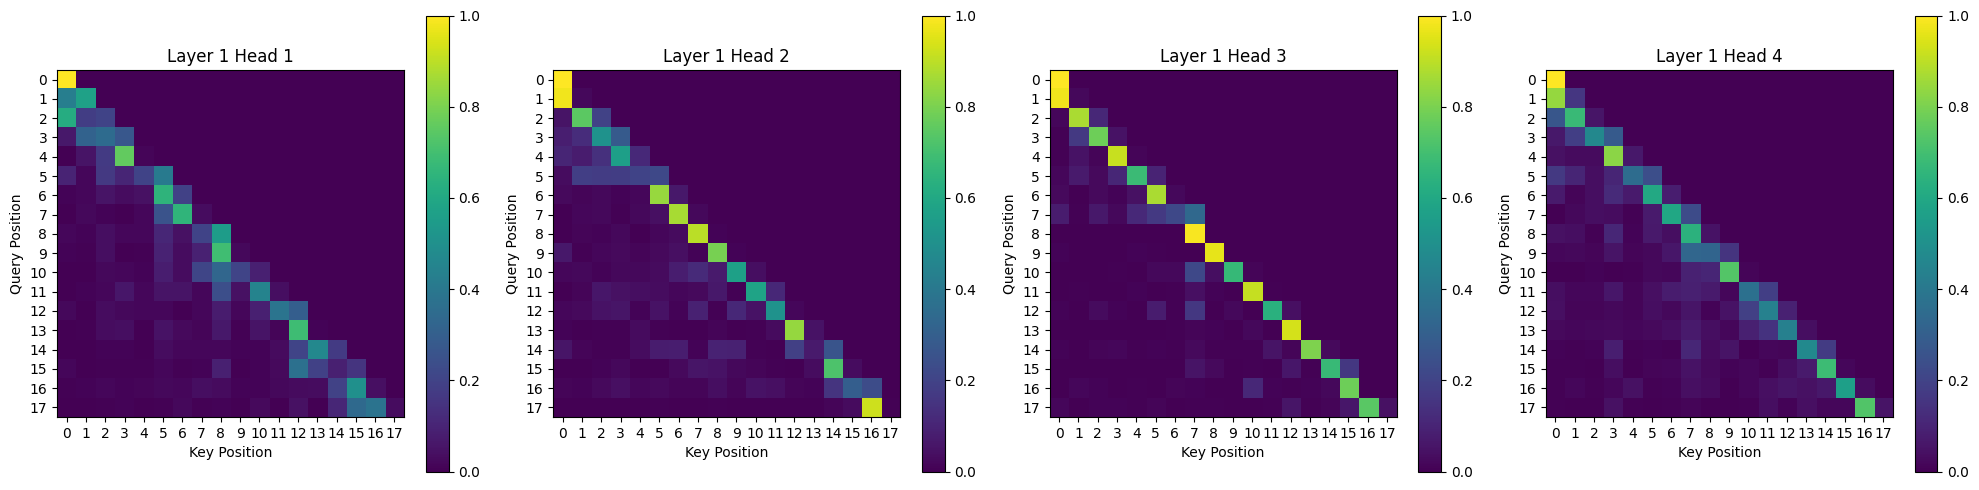

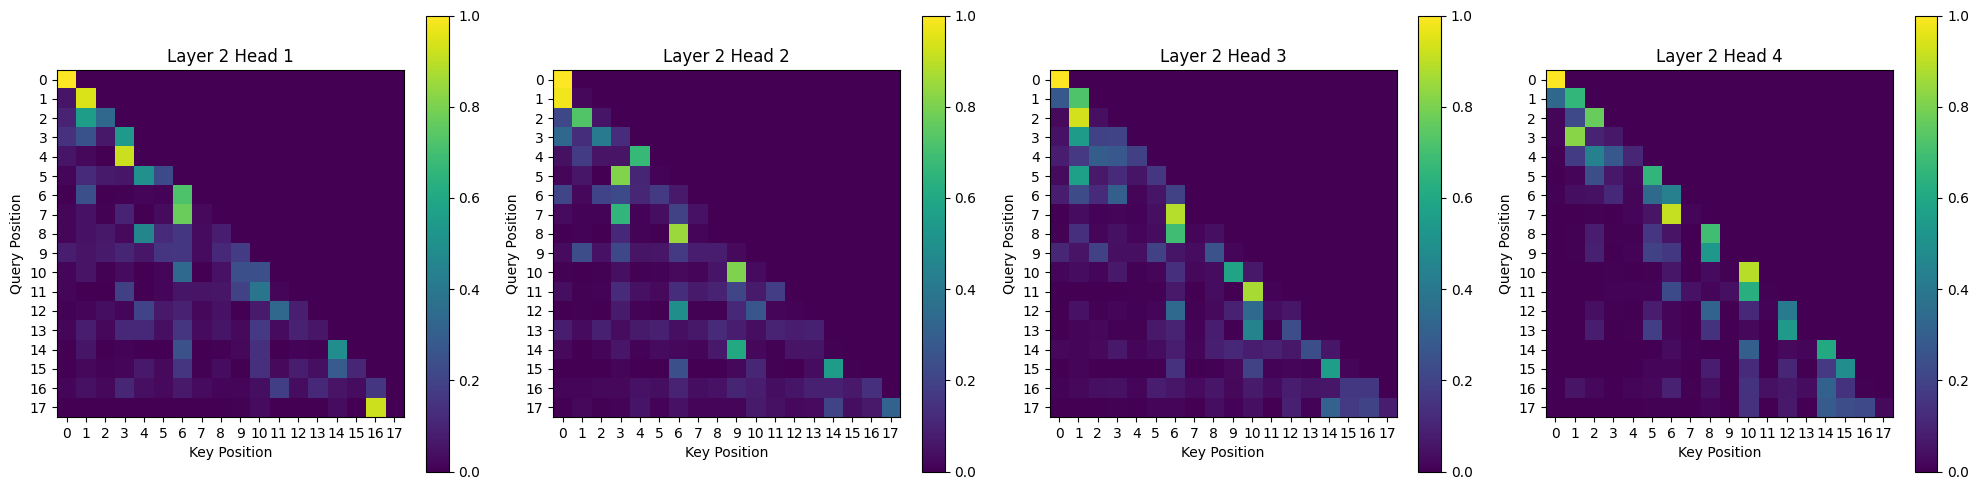

In [60]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

In [61]:
torch.save(model_moe.state_dict(), 'tinygpt_moe_model.pth')
print("MoE Model saved to tinygpt_moe_model.pth")

MoE Model saved to tinygpt_moe_model.pth


# Conclusions

- **Decoding Strategies:** The implementation of generateV2 successfully demonstrates various text generation strategies: greedy decoding, temperature sampling, and top-k/top-p sampling. Each strategy offers distinct control over the output's diversity and coherence, highlighting the trade-offs between predictability and creativity.

  - ***Greedy Decoding*** (temperature=0.0) produced highly repetitive output, as it consistently selects the token with the highest probability, often leading to loops or degenerate text.
  - ***Temperature Sampling*** (temperature=0.5, 1.0, 1.5) introduced controlled randomness. Lower temperatures yielded more conservative and predictable text, while higher temperatures increased diversity but could sometimes lead to less coherent output.
  - ***Top-k and Top-p Sampling*** provided more sophisticated control over the sampling pool. Top-k limits choices to the k most probable tokens, while Top-p adaptively selects tokens that collectively exceed a cumulative probability p, often resulting in more natural and varied text compared to pure temperature sampling.
- **Mixture of Experts (MoE)** Architecture: The integration of a Mixture of Experts layer into the TinyGPT model demonstrated a clear improvement in learning metrics.

  - The TinyGPT-MoE model achieved significantly lower training and validation losses (e.g., validation loss decreased from approximately 2.06 to 1.87) compared to the baseline TinyGPT model after the same number of training epochs. This suggests that incorporating specialized 'experts' allows the model to learn more efficiently and potentially improves its capacity to model the data.
  - The MoE structure enables sparse activation, meaning only a subset of experts are engaged for any given input token. This can lead to models with a large number of parameters (high capacity) but reduced computational cost during inference compared to a dense model of similar capacity.
- **Overall Learning:** This assignment provided a practical deep dive into the core components of GPT-like architectures, including attention mechanisms, feed-forward layers, and advanced text generation techniques. Furthermore, it offered hands-on experience in augmenting a transformer architecture with a Mixture of Experts layer, showcasing its potential benefits for model performance and efficiency.

# Congratulations! 🎉

After completing the tasks you've successfully pretrained for first GPT, remember to add your conclusions and findings! And you can now brag to your friend on how LLMs and GPTs work!

